In [1]:
import numpy as np
import healpy as hp
from healpy.newvisufunc import projview
from astropy.table import Table

import matplotlib
from matplotlib import pyplot as plt

import sys
sys.path.insert(0,'../code')
import utils

%load_ext autoreload
%autoreload 2

In [2]:
matplotlib.rcParams['ytick.labelsize'] = 18
matplotlib.rcParams['xtick.labelsize'] = 18
matplotlib.rcParams['axes.labelsize'] = 22
matplotlib.rcParams['legend.fontsize'] = 18

matplotlib.rc('text', usetex=True)

In [3]:
cmap_map = 'plasma'

# Zodi maps

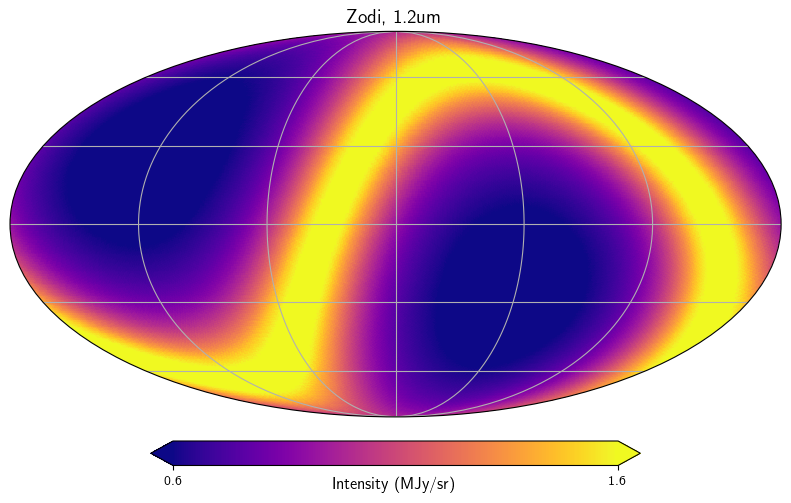

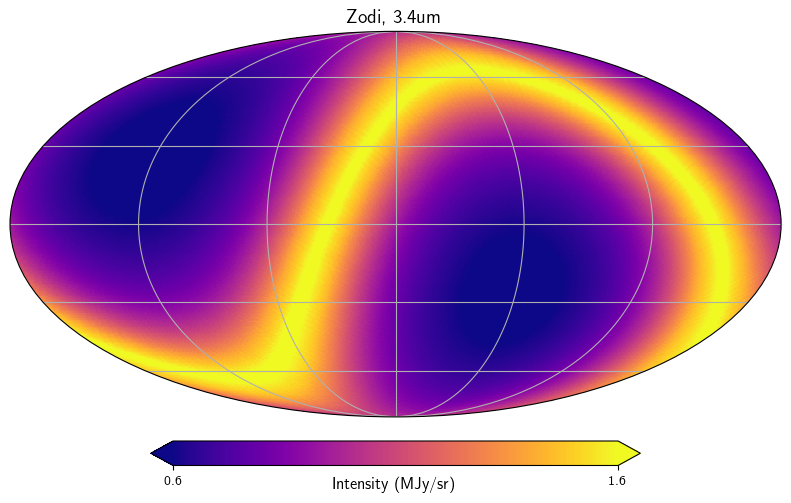

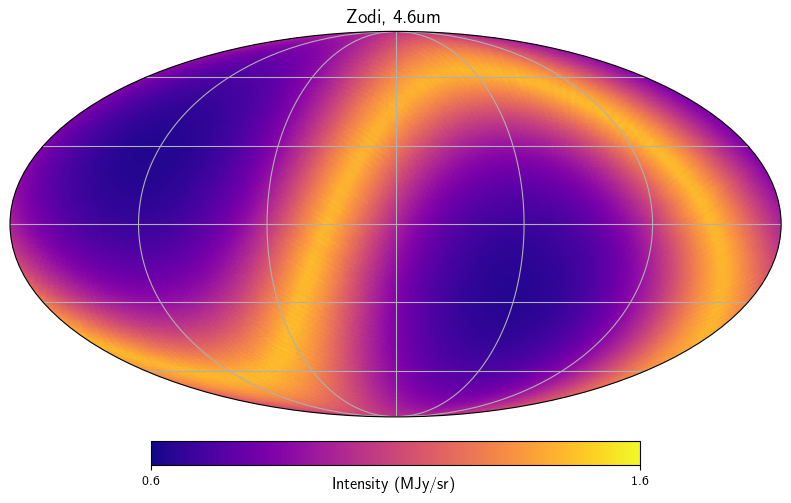

In [6]:
wls_zodi = ['1.2', '3.4', '4.6']
for wl_zodi in wls_zodi:
    fn_zodi = f'../data/maps/map_zodi{wl_zodi}_NSIDE64.npy'
    map_zodi = np.load(fn_zodi, allow_pickle=True)

    projview(map_zodi, title=f"Zodi, {wl_zodi}um",
             unit=r'Intensity (MJy/sr)', cmap=cmap_map, coord=['C', 'G'], 
             graticule=True, 
             min=0.6, max=1.6,
             #cbar_ticks=[0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
            )

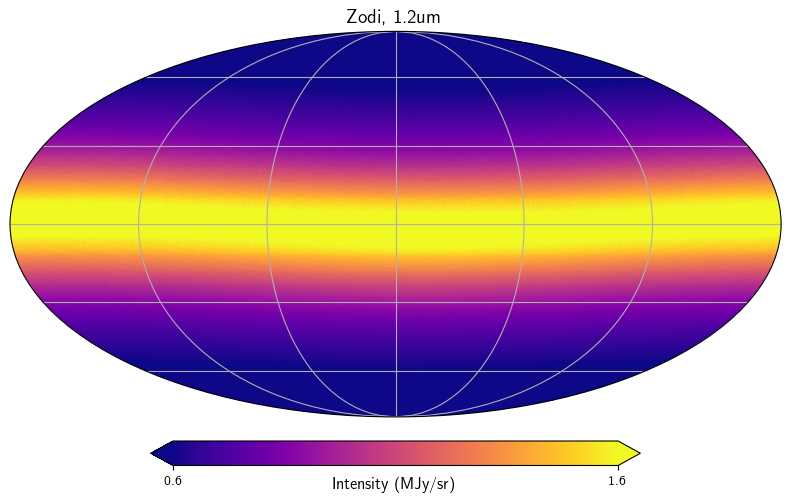

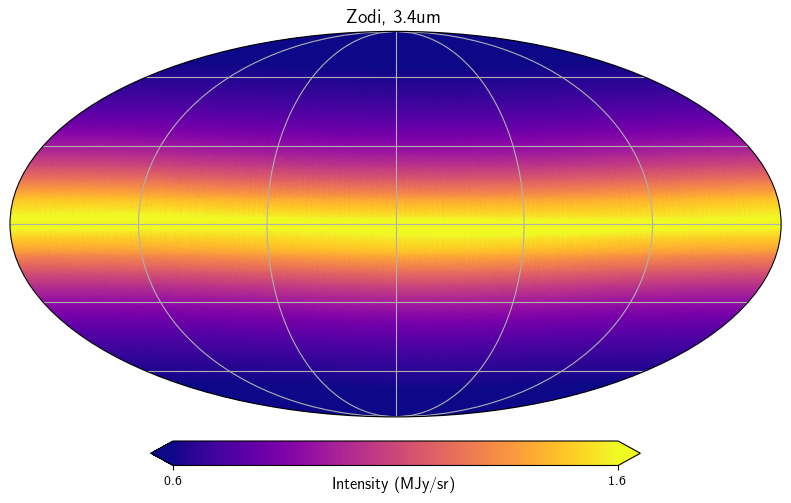

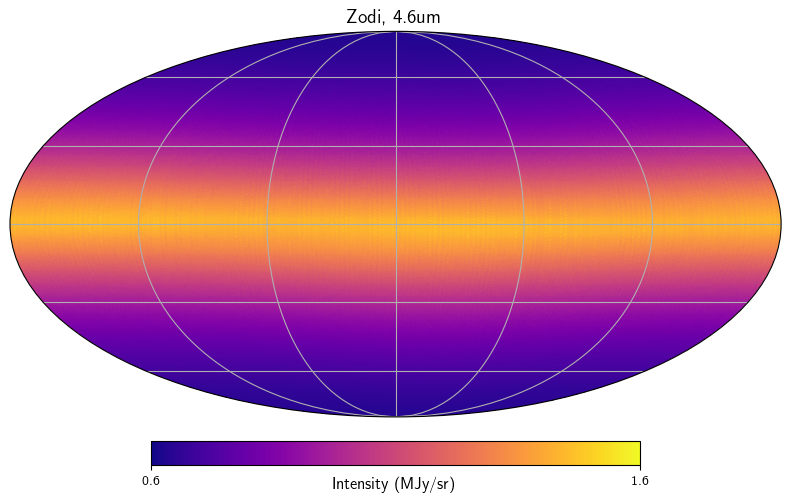

In [5]:
wls_zodi = ['1.2', '3.4', '4.6']
for wl_zodi in wls_zodi:
    fn_zodi = f'../data/maps/map_zodi{wl_zodi}_NSIDE64.npy'
    map_zodi = np.load(fn_zodi, allow_pickle=True)

    projview(map_zodi, title=f"Zodi, {wl_zodi}um",
             unit=r'Intensity (MJy/sr)', cmap=cmap_map, coord=['C'], 
             graticule=True, 
             min=0.6, max=1.6,
             #cbar_ticks=[0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
            )

# CatWISE

In [16]:
NSIDE = 64
NPIX = hp.nside2npix(NSIDE)
fac_stdev = 1.0

## Catalog

In [17]:
fn_catwise = '../data/catwise_agns_master_masks_w1_b15.fits'
tab_catwise = Table.read(fn_catwise)
N_catwise = len(tab_catwise)
print(N_catwise)

1921305


In [18]:
pixel_indices_catwise = hp.ang2pix(NSIDE, tab_catwise['ra'], tab_catwise['dec'], lonlat=True)
map_catwise = np.bincount(pixel_indices_catwise, minlength=NPIX)

In [19]:
np.min(map_catwise), np.max(map_catwise)

(0, 370)

In [20]:
#map_catwise[map_catwise==0

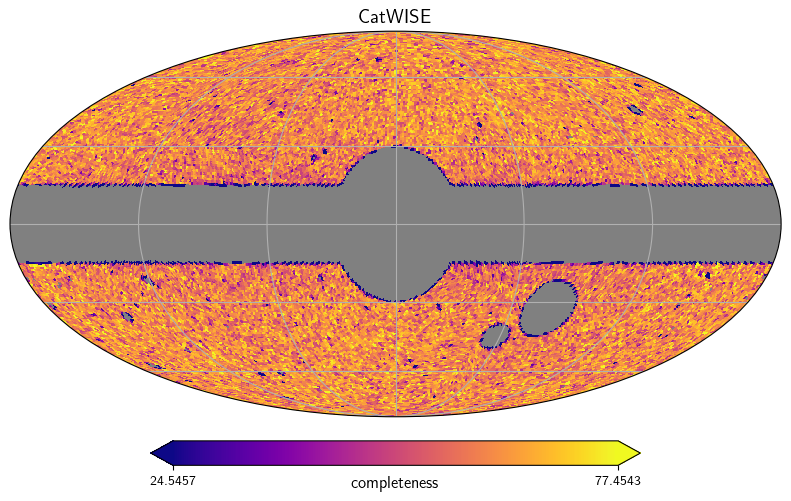

In [21]:
projview(map_catwise, title="CatWISE",
         unit="completeness", cmap=cmap_map, coord=['C', 'G'], 
         graticule=True, 
         norm='log',
         min=np.median(map_catwise)-fac_stdev*np.std(map_catwise), max=np.median(map_catwise)+fac_stdev*np.std(map_catwise), 
         #min=0.5, max=1.0,
         #cbar_ticks=[0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        )

## Selfuncs

In [13]:
tag_selfunc = ''
fn_selfunc = f'../data/maps/selection_function_NSIDE64_catwise{tag_selfunc}.fits'
#map_zodi = maps.get_unwise_scan_map(NSIDE, fn_map=fn_unwisescanmap)
map_selfunc = hp.read_map(fn_selfunc)
print(map_selfunc.shape)

(49152,)


In [14]:
np.min(map_selfunc), np.min(map_selfunc[map_selfunc>0]), np.max(map_selfunc)

(0.0, 0.2307519960839148, 3.192106069563906)

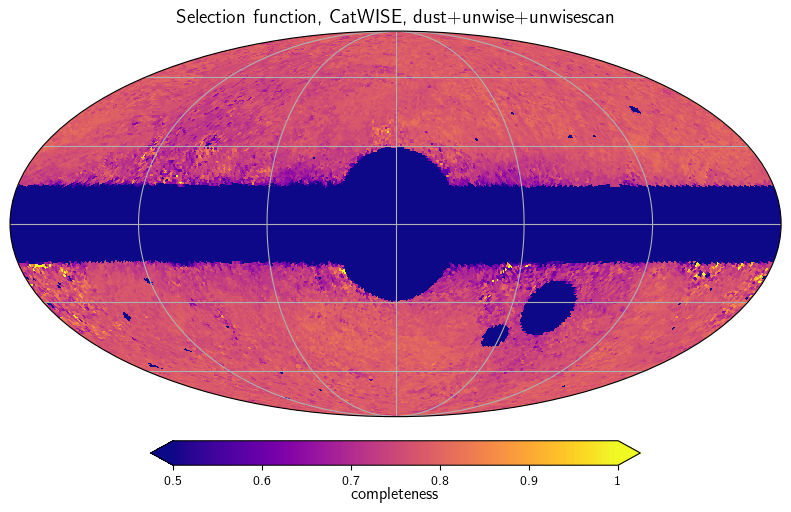

In [15]:
projview(map_selfunc, title="Selection function, CatWISE, dust+unwise+unwisescan",
         unit="completeness", cmap=cmap_map, coord=['C', 'G'], 
         graticule=True, 
         min=0.5, max=1.0,
         cbar_ticks=[0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        )

In [16]:
fn_rand = f'../data/randoms/random_catwise{tag_selfunc}_1x.fits'
tab_rand = Table.read(fn_rand)
N_rand = len(tab_rand)
print(f"Number of random sources: {N_rand}")

pixel_indices_rand = hp.ang2pix(NSIDE, tab_rand['ra'], tab_rand['dec'], lonlat=True)
map_rand = np.bincount(pixel_indices_rand, minlength=NPIX)

Number of random sources: 1920552


In [20]:
np.min(map_rand), np.min(map_catwise)

(0, 0)

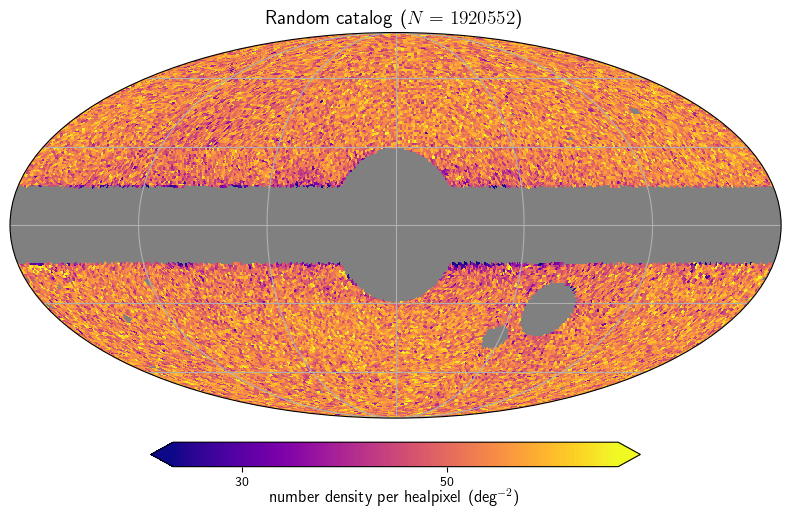

In [25]:
projview(map_rand, title=rf"Random catalog ($N={N_rand}$)",
            unit=r"number density per healpixel (deg$^{-2}$)", cmap=cmap_map, coord=['C', 'G'], 
            min=np.median(map_rand)-fac_stdev*np.std(map_rand), 
            max=np.median(map_rand)+fac_stdev*np.std(map_rand), 
            norm='log', graticule=True,
            cbar_ticks=[30, 50]
        ) 

147.9862567688028
RMSE: 2.0302229809976775


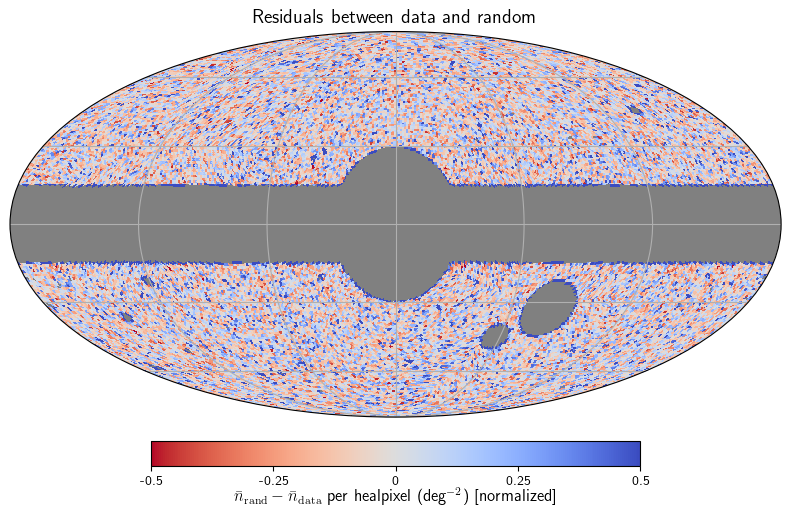

In [26]:
norm_factor = N_catwise/N_rand
i_nonzero = np.abs(map_catwise)>1e-8
map_residuals = np.full(len(map_rand), np.nan)
map_residuals[i_nonzero] = norm_factor*map_rand[i_nonzero]/map_catwise[i_nonzero] - 1

projview(map_residuals, title=rf"Residuals between data and random",
            unit=r"$\bar{n}_\mathrm{rand} - \bar{n}_\mathrm{data}$ per healpixel (deg$^{-2}$) [normalized]", 
            cmap='coolwarm_r', coord=['C', 'G'], 
            min=-0.5, max=0.5, graticule=True,
            cbar_ticks=[-0.5, -0.25, 0, 0.25, 0.5]) 

idx_nonzero_rand = map_rand>0 #bc using fractional error so getting nans
rmse_frac = utils.compute_rmse(norm_factor*map_rand[idx_nonzero_rand], map_catwise[idx_nonzero_rand], 
                               fractional=True)
print("RMSE:", rmse_frac)

In [23]:
tag_selfunc = '_dust'
fn_selfunc = f'../data/maps/selection_function_NSIDE64_catwise{tag_selfunc}.fits'
#map_zodi = maps.get_unwise_scan_map(NSIDE, fn_map=fn_unwisescanmap)
map_selfunc = hp.read_map(fn_selfunc)
print(map_selfunc.shape)
print(np.min(map_selfunc), np.min(map_selfunc[map_selfunc>0]), np.max(map_selfunc))

(49152,)
0.0 0.48502780284213465 1.9653387989539386


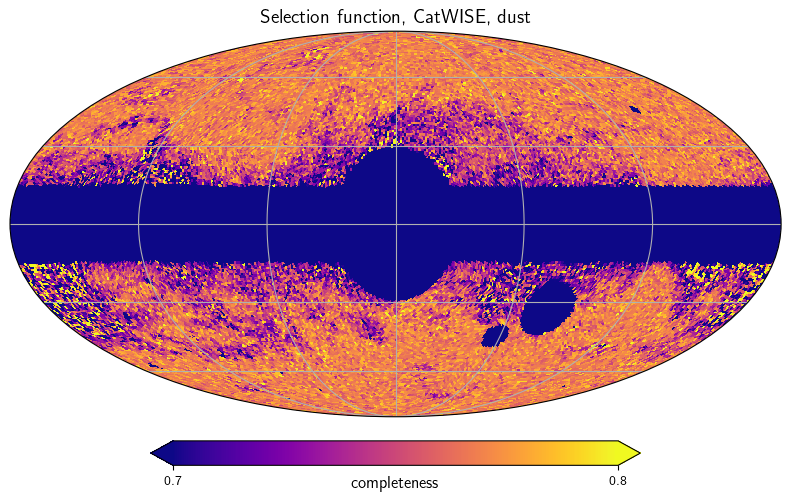

In [35]:
projview(map_selfunc, title="Selection function, CatWISE, dust",
         unit="completeness", cmap=cmap_map, coord=['C', 'G'], 
         graticule=True, 
         min=0.7, max=0.8,
         #cbar_ticks=[0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        )

Number of random sources: 1914949
RMSE: 2.2711283116665135


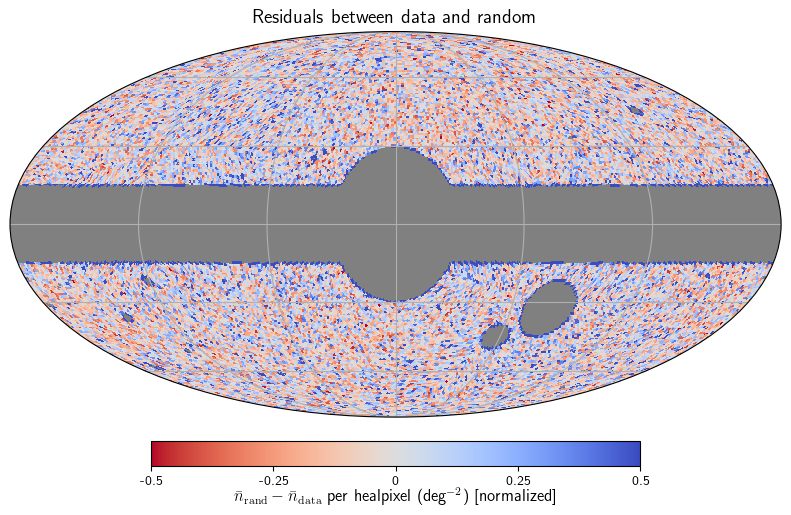

In [36]:
fn_rand = f'../data/randoms/random_catwise{tag_selfunc}_1x.fits'
tab_rand = Table.read(fn_rand)
N_rand = len(tab_rand)
print(f"Number of random sources: {N_rand}")

pixel_indices_rand = hp.ang2pix(NSIDE, tab_rand['ra'], tab_rand['dec'], lonlat=True)
map_rand = np.bincount(pixel_indices_rand, minlength=NPIX)

norm_factor = N_catwise/N_rand
i_nonzero = np.abs(map_catwise)>1e-8
map_residuals = np.full(len(map_rand), np.nan)
map_residuals[i_nonzero] = norm_factor*map_rand[i_nonzero]/map_catwise[i_nonzero] - 1

projview(map_residuals, title=rf"Residuals between data and random",
            unit=r"$\bar{n}_\mathrm{rand} - \bar{n}_\mathrm{data}$ per healpixel (deg$^{-2}$) [normalized]", 
            cmap='coolwarm_r', coord=['C', 'G'], 
            min=-0.5, max=0.5, graticule=True,
            cbar_ticks=[-0.5, -0.25, 0, 0.25, 0.5]) 

idx_nonzero_rand = map_rand>0 #bc using fractional error so getting nans
rmse_frac = utils.compute_rmse(norm_factor*map_rand[idx_nonzero_rand], map_catwise[idx_nonzero_rand], 
                               fractional=True)
print("RMSE:", rmse_frac)

In [31]:
tag_selfunc = '_zodi3.4'
fn_selfunc = f'../data/maps/selection_function_NSIDE64_catwise{tag_selfunc}.fits'
#map_zodi = maps.get_unwise_scan_map(NSIDE, fn_map=fn_unwisescanmap)
map_selfunc = hp.read_map(fn_selfunc)
print(map_selfunc.shape)
print(np.min(map_selfunc), np.min(map_selfunc[map_selfunc>0]), np.max(map_selfunc))

(49152,)
0.0 0.6149974399912023 0.65082316918108


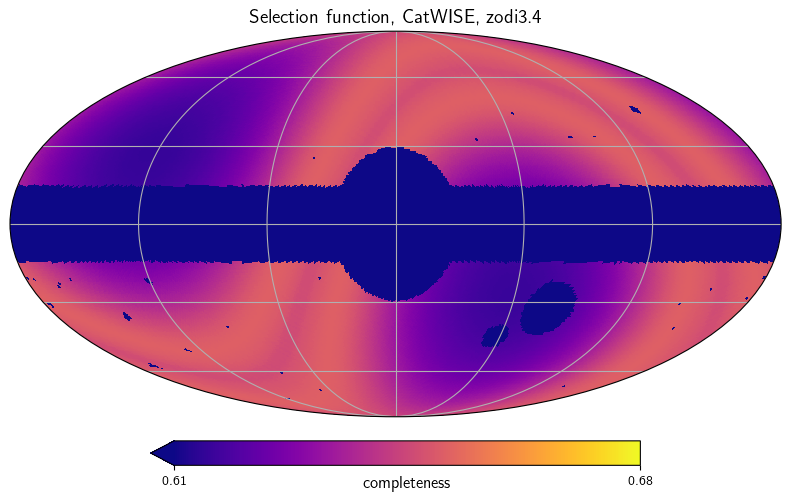

In [35]:
projview(map_selfunc, title="Selection function, CatWISE, zodi3.4",
         unit="completeness", cmap=cmap_map, coord=['C', 'G'], 
         graticule=True, 
         min=0.61, max=0.68,
         #cbar_ticks=[0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        )

Number of random sources: 1921197
RMSE: 2.307254855525668


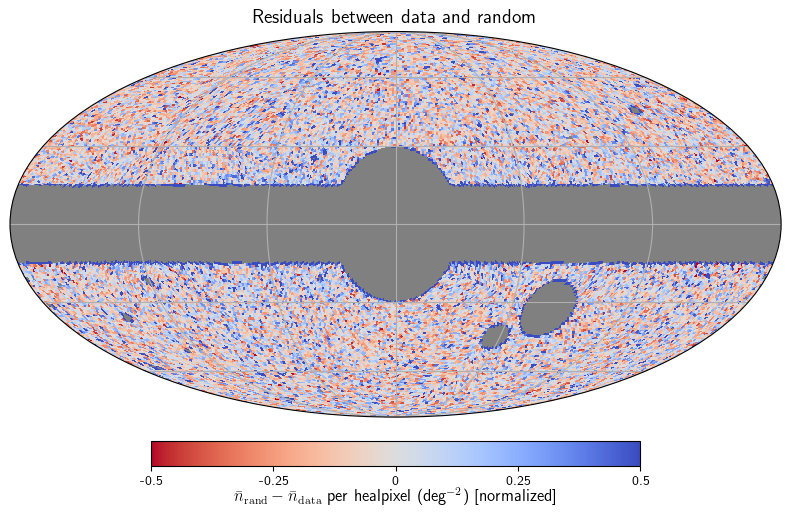

In [37]:
fn_rand = f'../data/randoms/random_catwise{tag_selfunc}_1x.fits'
tab_rand = Table.read(fn_rand)
N_rand = len(tab_rand)
print(f"Number of random sources: {N_rand}")

pixel_indices_rand = hp.ang2pix(NSIDE, tab_rand['ra'], tab_rand['dec'], lonlat=True)
map_rand = np.bincount(pixel_indices_rand, minlength=NPIX)

norm_factor = N_catwise/N_rand
i_nonzero = np.abs(map_catwise)>1e-8
map_residuals = np.full(len(map_rand), np.nan)
map_residuals[i_nonzero] = norm_factor*map_rand[i_nonzero]/map_catwise[i_nonzero] - 1

projview(map_residuals, title=rf"Residuals between data and random",
            unit=r"$\bar{n}_\mathrm{rand} - \bar{n}_\mathrm{data}$ per healpixel (deg$^{-2}$) [normalized]", 
            cmap='coolwarm_r', coord=['C', 'G'], 
            min=-0.5, max=0.5, graticule=True,
            cbar_ticks=[-0.5, -0.25, 0, 0.25, 0.5]) 

idx_nonzero_rand = map_rand>0 #bc using fractional error so getting nans
rmse_frac = utils.compute_rmse(norm_factor*map_rand[idx_nonzero_rand], map_catwise[idx_nonzero_rand], 
                               fractional=True)
print("RMSE:", rmse_frac)

In [38]:
tag_selfunc = '_dustzodi3.4'
fn_selfunc = f'../data/maps/selection_function_NSIDE64_catwise{tag_selfunc}.fits'
#map_zodi = maps.get_unwise_scan_map(NSIDE, fn_map=fn_unwisescanmap)
map_selfunc = hp.read_map(fn_selfunc)
print(map_selfunc.shape)
print(np.min(map_selfunc), np.min(map_selfunc[map_selfunc>0]), np.max(map_selfunc))

(49152,)
0.0 0.33201501586270366 2.329149782407613


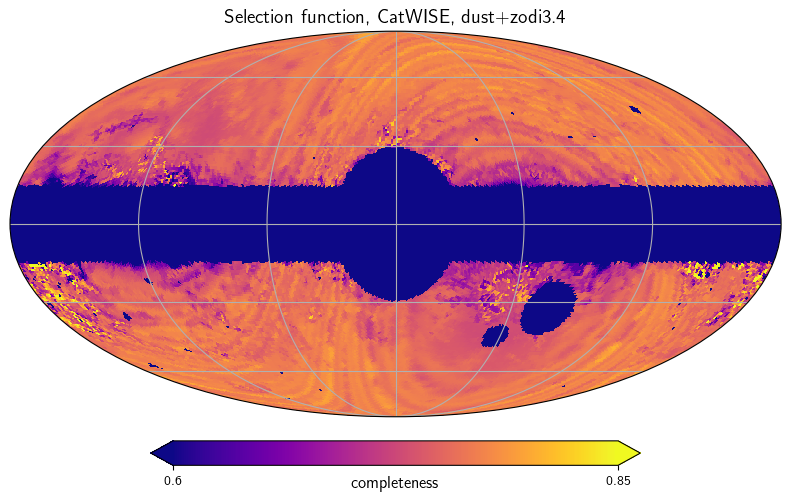

In [42]:
projview(map_selfunc, title="Selection function, CatWISE, dust+zodi3.4",
         unit="completeness", cmap=cmap_map, coord=['C', 'G'], 
         graticule=True, 
         #min=0.6, max=0.68,
         min=0.6, max=0.85
         #cbar_ticks=[0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        )

Number of random sources: 1914128
RMSE: 2.1030649356572613


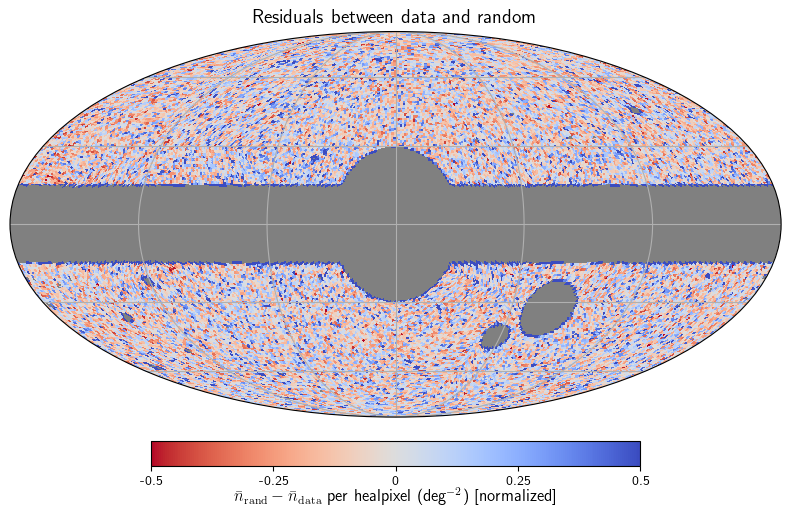

In [43]:
fn_rand = f'../data/randoms/random_catwise{tag_selfunc}_1x.fits'
tab_rand = Table.read(fn_rand)
N_rand = len(tab_rand)
print(f"Number of random sources: {N_rand}")

pixel_indices_rand = hp.ang2pix(NSIDE, tab_rand['ra'], tab_rand['dec'], lonlat=True)
map_rand = np.bincount(pixel_indices_rand, minlength=NPIX)

norm_factor = N_catwise/N_rand
i_nonzero = np.abs(map_catwise)>1e-8
map_residuals = np.full(len(map_rand), np.nan)
map_residuals[i_nonzero] = norm_factor*map_rand[i_nonzero]/map_catwise[i_nonzero] - 1

projview(map_residuals, title=rf"Residuals between data and random",
            unit=r"$\bar{n}_\mathrm{rand} - \bar{n}_\mathrm{data}$ per healpixel (deg$^{-2}$) [normalized]", 
            cmap='coolwarm_r', coord=['C', 'G'], 
            min=-0.5, max=0.5, graticule=True,
            cbar_ticks=[-0.5, -0.25, 0, 0.25, 0.5]) 

idx_nonzero_rand = map_rand>0 #bc using fractional error so getting nans
rmse_frac = utils.compute_rmse(norm_factor*map_rand[idx_nonzero_rand], map_catwise[idx_nonzero_rand], 
                               fractional=True)
print("RMSE:", rmse_frac)

In [44]:
tag_selfunc = '_zodis'
fn_selfunc = f'../data/maps/selection_function_NSIDE64_catwise{tag_selfunc}.fits'
#map_zodi = maps.get_unwise_scan_map(NSIDE, fn_map=fn_unwisescanmap)
map_selfunc = hp.read_map(fn_selfunc)
print(map_selfunc.shape)
print(np.min(map_selfunc), np.min(map_selfunc[map_selfunc>0]), np.max(map_selfunc))

(49152,)
0.0 0.6218524282472105 0.6580176419246881


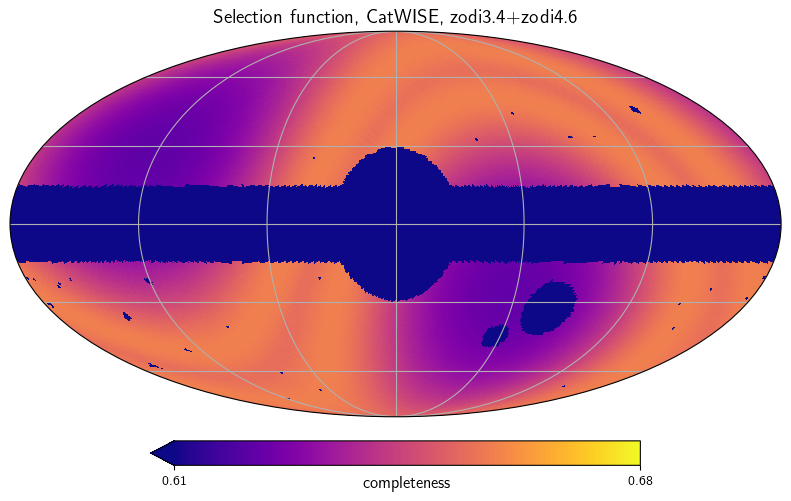

In [45]:
projview(map_selfunc, title="Selection function, CatWISE, zodi3.4+zodi4.6",
         unit="completeness", cmap=cmap_map, coord=['C', 'G'], 
         graticule=True, 
         min=0.61, max=0.68,
         #cbar_ticks=[0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        )

Number of random sources: 1920114
RMSE: 2.297704694078149


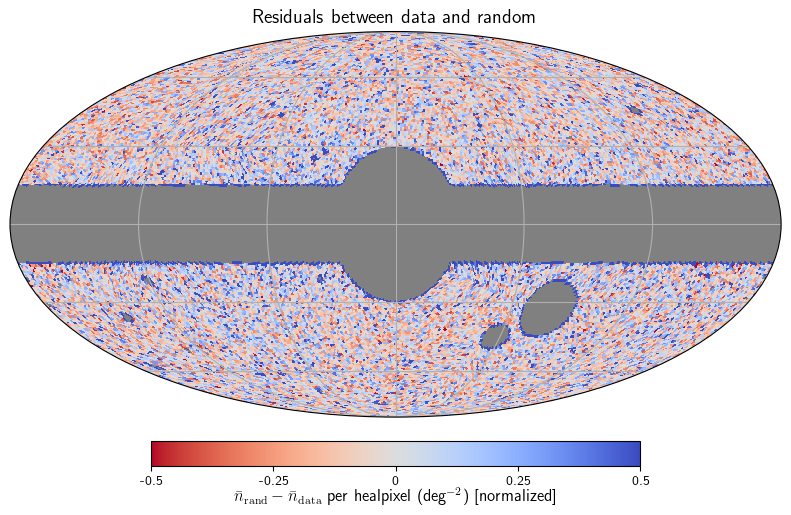

In [46]:
fn_rand = f'../data/randoms/random_catwise{tag_selfunc}_1x.fits'
tab_rand = Table.read(fn_rand)
N_rand = len(tab_rand)
print(f"Number of random sources: {N_rand}")

pixel_indices_rand = hp.ang2pix(NSIDE, tab_rand['ra'], tab_rand['dec'], lonlat=True)
map_rand = np.bincount(pixel_indices_rand, minlength=NPIX)

norm_factor = N_catwise/N_rand
i_nonzero = np.abs(map_catwise)>1e-8
map_residuals = np.full(len(map_rand), np.nan)
map_residuals[i_nonzero] = norm_factor*map_rand[i_nonzero]/map_catwise[i_nonzero] - 1

projview(map_residuals, title=rf"Residuals between data and random",
            unit=r"$\bar{n}_\mathrm{rand} - \bar{n}_\mathrm{data}$ per healpixel (deg$^{-2}$) [normalized]", 
            cmap='coolwarm_r', coord=['C', 'G'], 
            min=-0.5, max=0.5, graticule=True,
            cbar_ticks=[-0.5, -0.25, 0, 0.25, 0.5]) 

idx_nonzero_rand = map_rand>0 #bc using fractional error so getting nans
rmse_frac = utils.compute_rmse(norm_factor*map_rand[idx_nonzero_rand], map_catwise[idx_nonzero_rand], 
                               fractional=True)
print("RMSE:", rmse_frac)

In [37]:
tag_selfunc = '_pluszodis'
fn_selfunc = f'../data/maps/selection_function_NSIDE64_catwise{tag_selfunc}.fits'
#map_zodi = maps.get_unwise_scan_map(NSIDE, fn_map=fn_unwisescanmap)
map_selfunc = hp.read_map(fn_selfunc)
print(map_selfunc.shape)
print(np.min(map_selfunc), np.min(map_selfunc[map_selfunc>0]), np.max(map_selfunc))

(49152,)
0.0 0.2673651148434092 2.4739187871320856


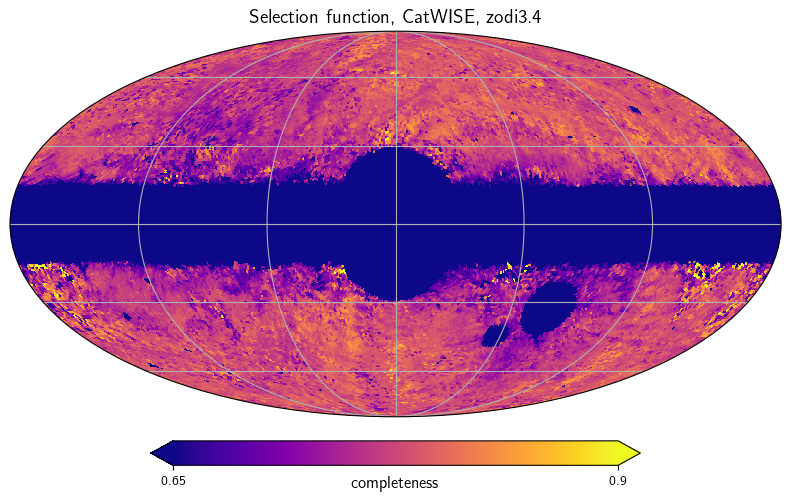

In [43]:
projview(map_selfunc, title="Selection function, CatWISE, zodi3.4",
         unit="completeness", cmap=cmap_map, coord=['C', 'G'], 
         graticule=True, 
         min=0.65, max=0.9,
         #cbar_ticks=[0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        )

Number of random sources: 1917887
RMSE: 1.9414663164164


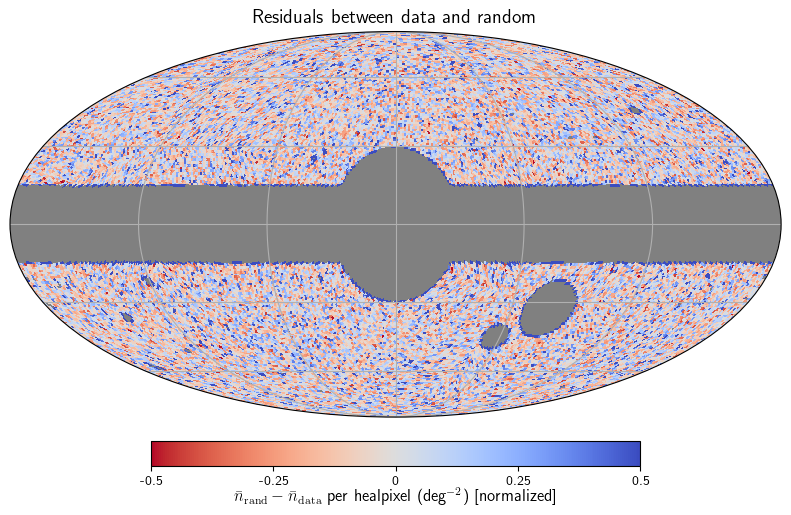

In [39]:
fn_rand = f'../data/randoms/random_catwise{tag_selfunc}_1x.fits'
tab_rand = Table.read(fn_rand)
N_rand = len(tab_rand)
print(f"Number of random sources: {N_rand}")

pixel_indices_rand = hp.ang2pix(NSIDE, tab_rand['ra'], tab_rand['dec'], lonlat=True)
map_rand = np.bincount(pixel_indices_rand, minlength=NPIX)

norm_factor = N_catwise/N_rand
i_nonzero = np.abs(map_catwise)>1e-8
map_residuals = np.full(len(map_rand), np.nan)
map_residuals[i_nonzero] = norm_factor*map_rand[i_nonzero]/map_catwise[i_nonzero] - 1

projview(map_residuals, title=rf"Residuals between data and random",
            unit=r"$\bar{n}_\mathrm{rand} - \bar{n}_\mathrm{data}$ per healpixel (deg$^{-2}$) [normalized]", 
            cmap='coolwarm_r', coord=['C', 'G'], 
            min=-0.5, max=0.5, graticule=True,
            cbar_ticks=[-0.5, -0.25, 0, 0.25, 0.5]) 

idx_nonzero_rand = map_rand>0 #bc using fractional error so getting nans
rmse_frac = utils.compute_rmse(norm_factor*map_rand[idx_nonzero_rand], map_catwise[idx_nonzero_rand], 
                               fractional=True)
print("RMSE:", rmse_frac)

## Abby version removing edges

In [5]:
fn_catwise = '~/code/quasar_data_abby/catalogs/catwise_agns/masked_catwise_agns_master_blim15.fits'
map_catwise = hp.read_map(fn_catwise)
print(map_catwise.shape)

(49152,)


In [13]:
i_notnan = ~np.isnan(map_catwise)
map_catwise[~i_notnan] = hp.UNSEEN
np.median(map_catwise[i_notnan]), np.std(map_catwise[i_notnan])

(51.0, 7.607656840991593e+29)

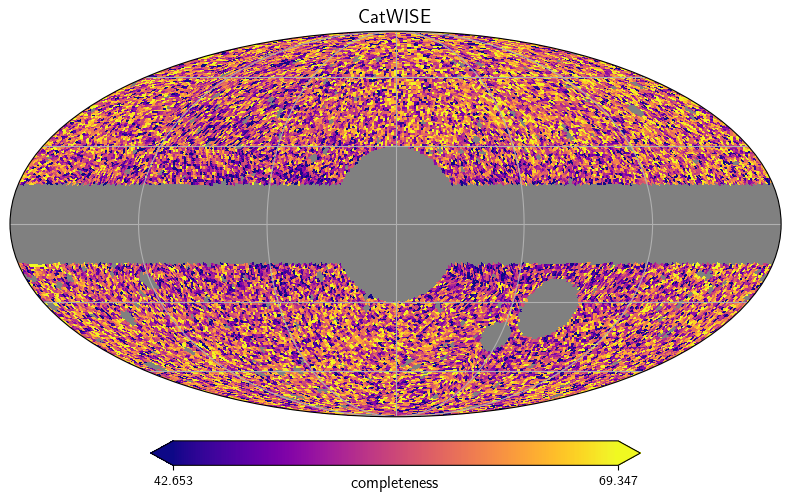

In [15]:
fac_stdev = 1.5
projview(map_catwise, title="CatWISE",
         unit="completeness", cmap=cmap_map, coord=['C', 'G'], 
         graticule=True, 
         norm='log',
         min=np.median(map_catwise[i_notnan])-fac_stdev*np.std(map_catwise[i_notnan]), 
         max=np.median(map_catwise[i_notnan])+fac_stdev*np.std(map_catwise[i_notnan]), 
         #min=10, max=np.median(map_catwise)+fac_stdev*np.std(map_catwise), 
         #min=0.5, max=1.0,
         #cbar_ticks=[0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        )

# Quaia

In [47]:
G_lo = '20.0'
fn_gcatlo = f'../data/quaia_G{G_lo}.fits'
tab_gcatlo = utils.load_table(fn_gcatlo)
N_gcatlo = len(tab_gcatlo)
print(N_gcatlo)

755850


In [48]:
pixel_indices_gcatlo = hp.ang2pix(NSIDE, tab_gcatlo['ra'], tab_gcatlo['dec'], lonlat=True)
map_gcatlo = np.bincount(pixel_indices_gcatlo, minlength=NPIX)

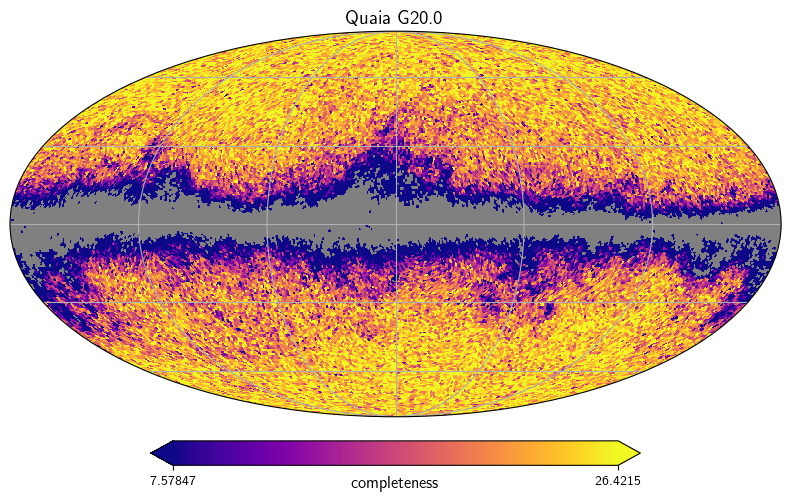

In [49]:
projview(map_gcatlo, title=f"Quaia G{G_lo}",
         unit="completeness", cmap=cmap_map, coord=['C', 'G'], 
         graticule=True, 
         norm='log',
         min=np.median(map_gcatlo)-fac_stdev*np.std(map_gcatlo), 
         max=np.median(map_gcatlo)+fac_stdev*np.std(map_gcatlo), 
         #min=0.5, max=1.0,
         #cbar_ticks=[0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        )

In [51]:
tag_selfunc = '_pluszodi3.4nomcs'
fn_selfunc = f'../data/maps/selection_function_NSIDE64_G{G_lo}{tag_selfunc}.fits'
#map_zodi = maps.get_unwise_scan_map(NSIDE, fn_map=fn_unwisescanmap)
map_selfunc = hp.read_map(fn_selfunc)
print(map_selfunc.shape)
print(np.min(map_selfunc), np.min(map_selfunc[map_selfunc>0]), np.max(map_selfunc))

(49152,)
0.0 0.0265644581995862 0.8039818567990371


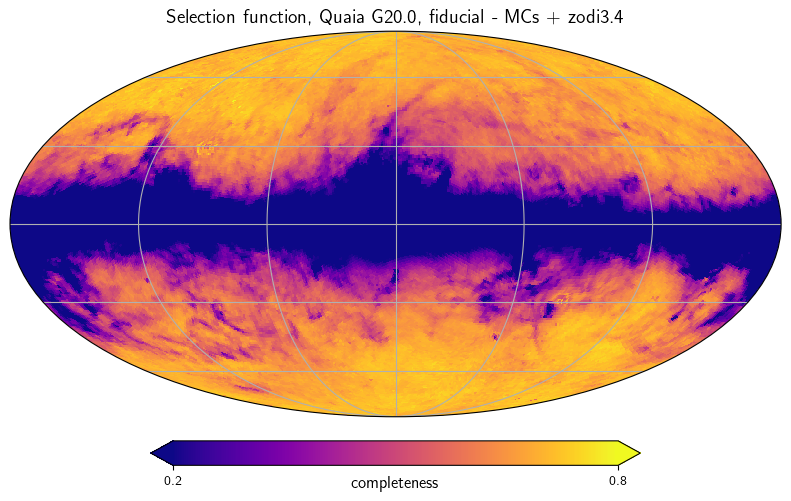

In [55]:
projview(map_selfunc, title=f"Selection function, Quaia G{G_lo}, fiducial - MCs + zodi3.4",
         unit="completeness", cmap=cmap_map, coord=['C', 'G'], 
         graticule=True, 
         min=0.2, max=0.8,
         #cbar_ticks=[0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        )

Number of random sources: 755946
RMSE: 0.6148600504523962


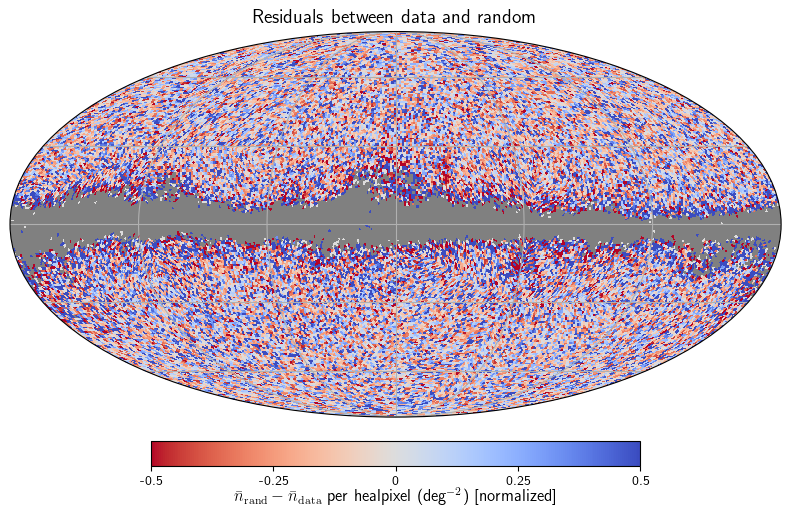

In [56]:
fn_rand = f'../data/randoms/random_G{G_lo}{tag_selfunc}_1x.fits'
tab_rand = Table.read(fn_rand)
N_rand = len(tab_rand)
print(f"Number of random sources: {N_rand}")

pixel_indices_rand = hp.ang2pix(NSIDE, tab_rand['ra'], tab_rand['dec'], lonlat=True)
map_rand = np.bincount(pixel_indices_rand, minlength=NPIX)

norm_factor = N_gcatlo/N_rand
i_nonzero = np.abs(map_gcatlo)>1e-8
map_residuals = np.full(len(map_rand), np.nan)
map_residuals[i_nonzero] = norm_factor*map_rand[i_nonzero]/map_gcatlo[i_nonzero] - 1

projview(map_residuals, title=rf"Residuals between data and random",
            unit=r"$\bar{n}_\mathrm{rand} - \bar{n}_\mathrm{data}$ per healpixel (deg$^{-2}$) [normalized]", 
            cmap='coolwarm_r', coord=['C', 'G'], 
            min=-0.5, max=0.5, graticule=True,
            cbar_ticks=[-0.5, -0.25, 0, 0.25, 0.5]) 

idx_nonzero_rand = map_rand>0 #bc using fractional error so getting nans
rmse_frac = utils.compute_rmse(norm_factor*map_rand[idx_nonzero_rand], map_gcatlo[idx_nonzero_rand], 
                               fractional=True)
print("RMSE:", rmse_frac)

fiducial is RMSE frac: 0.4894113405554599 - but could be driven by MCs